# 6. Hidden Markov Models with Theano and TensorFlow
In the last section we went over the training and prediction procedures of Hidden Markov Models. This was all done using only vanilla numpy the Expectation Maximization algorithm. I now want to introduce how both `Theano` and `Tensorflow` can be utilized to accomplish the same goal, albeit by a very different process. 

## 1. Gradient Descent
Hopefully you are familiar with the gradient descent optimization algorithm, if not I recommend reviewing my posts on Deep Learning, which leverage gradient descent heavily (or this [video](https://www.youtube.com/watch?v=IHZwWFHWa-w). With that said, a simple overview is as follows:

> Gradient descent is a first order optimization algorithm for finding the minimum of a function. To find a local minimum of a function using gradient descent, on takes steps proportional to the negative of the gradient of the function at its current point. 

Visually, this iterative process looks like: 

<img src="https://drive.google.com/uc?id=1R2zVTj3uo5zmow6vFujWlU-qs9jRF_XG" width="250">

Where above we are looking at a contour plot of a three dimensional bowl, and the center of the bowl is a minimum. Now, the actual underlying mechanics of gradient descent work as follows:
1. Define a model/hypothesis that will be mapping inputs to outputs, or in other words making predictions:

$$h_{\theta}(x) = \theta_0 + \theta_1x$$

In this case $x$ is our input and $h(x)$, often thought of as $y$, is our output. We are stating that we believe the ground truth relationship between $x$ and $h(x)$ is captured by the linear combination of $\theta_0 + \theta_1x$. Now, what are $\theta_0$ and $\theta_1$ equal to? 

2. Define a **cost** function for which you are trying to find the minimum. Generally, this cost function is defined as some form of **error**, and it will be parameterized by variables related to your model in some way. 

$$cost = J = (y - h_{\theta}(x))^2$$

Above $y$ refers to the ground truth/actual value of the output, and $h_{\theta}(x)$ refers to that which our model predicted. The difference, squared, represents our cost. We can see that if our prediction is exactly equal to the ground truth value, our cost will be 0. If our prediction is very far off from our ground truth value then our cost will be very high. Our goal is to minimize the cost (error) of our model. 

2. Take the [**gradient**](https://en.wikipedia.org/wiki/Gradient) (multi-variable generalization of the derivative) of the cost function with respect to the parameters that you have control over.

$$\nabla J = \frac{\partial J}{\partial \theta}$$

Simply put, we want to see how $J$ changes as we change our model parameters, $\theta_0$ and $\theta_1$. 

3. Based on the gradient update our values for $\theta$ with a simple update rule:

$$\theta_0 \rightarrow \theta_0 - \alpha \cdot \frac{\partial J}{\partial \theta_0}$$

$$\theta_1 \rightarrow \theta_1 - \alpha \cdot \frac{\partial J}{\partial \theta_1}$$

4. Repeat steps two and three for a set number of iterations/until convergence.

After a set number of steps, the hope is that the model weights that were _learned_ are the most optimal weights to minimize prediction error. Now after everything we discussed in the past two posts you may be wondering, how exactly does this relate to Hidden Markov Models, which have been trained via Expectation Maximization?

### 1.1 Gradient Descent and Hidden Markov Models
Let's say for a moment that our goal that we wish to accomplish is predict the probability of an observed sequence, $p(x)$. And let's say that we have 100 observed sequences at our disposal. It should be clear that if we have a trained HMM that predicts the majority of our sequences are very unlikely, the HMM was probably not trained very well. Ideally, our HMM parameters would be learned in a way that maximizes the probability of observing what we did (this was the goal of expectation maximization).

What may start to become apparent at this point is that we have a perfect cost function already created for us! The total probability of our observed sequences, based on our HMM parameters $A$, $B$, and $\pi$. We can define this mathematically as follows (for the scaled version); in the previous post we proved that:

$$p(x) = \prod_{t=1}^T c(t)$$

Which states that the probability of an observed sequence is equal to the product of the scales at each time step. Also recall that the scale is just defined as:

$$c(t) = \sum_{i=1}^M \alpha'(t,i)$$

With that all said, we can define the cost of a single observed training sequence as:

$$cost = \sum_{t}^{T} log\big(c(t)\big)$$

Where we are using the log to avoid the underflow problem, just as we did in the last notebook. So, we have a cost function which intuitively makes sense, but can we find its gradient with respect to our HMM parameters $A$, $B$, and $\pi$? We absolutely can! The wonderful thing about Theano is that it links variables together via a [computational graph](http://deeplearning.net/software/theano/extending/graphstructures.html). So, cost is depedent on $A$, $B$ and $\pi$ via the following link:

$$cost \rightarrow c(t) \rightarrow alpha \rightarrow A, B, \pi$$

We can take the gradient of this cost function in theano as well, allowing us to then easily update our values of $A$, $B$, and $\pi$! Done iteratively, we hopefully will converge to a nice minimum.

### 1.2 HMM Theano specifics
I would be lying if I said that Theano wasn't a little bit hard to follow at first. For those unfamiliar, representing symbolic mathematical computations as graphs may feel very strange. I have a few walk throughs of Theano in my Deep Learning section, as well as `.py` files in the source repo. Additionally, the theano [documentation](http://deeplearning.net/software/theano/index.html) is also very good. With that said, I do want to discuss a few details of the upcoming code block. 

#### Recurrence Block $\rightarrow$ Calculating the Forward Variable, $\alpha$
First, I want to discuss the `recurrence` and `scan` functions that you will be seeing:

```
def recurrence_to_find_alpha(t, old_alpha, x):
    """Scaled version of updates for HMM. This is used to 
    find the forward variable alpha.

        Args:
            t:         Current time step, from pass in from scan:
                       sequences=T.arange(1, thx.shape[0])
            old_alpha: Previously returned alpha, or on the first time 
                       step the initial value,
                       outputs_info=[self.pi *  self.B[:, thx[0]], None]
            x:         thx, non_sequences (our actual set of observations)
    """
    alpha = old_alpha.dot(self.A) * self.B[:, x[t]]
    s = alpha.sum()
    return (alpha / s), s

# alpha and scale, once returned, are both matrices with values at each time step
[alpha, scale], _ = theano.scan(
    fn=recurrence_to_find_alpha,
    sequences=T.arange(1, thx.shape[0]),
    outputs_info=[self.pi *  self.B[:, thx[0]], None],    # Initial value of alpha
    n_steps=thx.shape[0] - 1,
    non_sequences=thx,
)

# scale is an array, and scale.prod() = p(x)
# The property log(A) + log(B) = log(AB) can be used 
# here to prevent underflow problem
p_of_x = -T.log(scale).sum()      # Negative log likelihood
cost = p_of_x

self.cost_op = theano.function(
    inputs=[thx],
    outputs=cost,
    allow_input_downcast=True,
)

```

The above block is where our forward variable $\alpha$ and subsequently the probability of the observed sequence $p(x)$ is found. The process works as follows:
1. The `theano.scan` function (logically similar to a for loop) is defined with the following parameters:
    * `fn`: The recurrence function that the array being iterated over will be passed into.
    * `sequences`: An array of indexes, $[1,2,3,...,T]$
    * `outputs_info`: The initial value of $\alpha$
    * `non_sequences`: Our observation sequence, $X$. This passed in it's entirety to the recurrence function at each iteration.
2. Our recurrence function, `recurrence_to_find_alpha`, is meant to calculate $\alpha$ at each time step. $\alpha$ at $t=1$ was defined by `outputs_info` in `scan`. This recurrence function essentially is performing the forward algorithm (additionally it incorporates scaling):

$$\alpha(1,i) = \pi_iB\big(i, x(1)\big)$$

$$\alpha(t+1, j) = \sum_{i=1}^M \alpha(t,i) A(i,j)B(j, x(t+1))$$

3. We calculate $p(x)$ to be the sum of the log likelihood. This is set to be our `cost`.
4. We define a `cost_op`, which is a theano function that takes in a symbolic variable `thx` and determines the output `cost`. Remember, `cost` is linked to `thx` via:

```
cost -> scale -> theano.scan(non_sequences=thx)
```

#### Update block $\rightarrow$ Updating HMM parameters $A$, $B$, and $\pi$
The other block that I want to touch on is the update block:

```
pi_update = self.pi - learning_rate * T.grad(cost, self.pi)
pi_update = pi_update / pi_update.sum()

A_update = self.A - learning_rate*T.grad(cost, self.A)
A_update = A_update / A_update.sum(axis=1).dimshuffle(0, 'x')

B_update = self.B - learning_rate*T.grad(cost, self.B)
B_update = B_update / B_update.sum(axis=1).dimshuffle(0, 'x')

updates = [
    (self.pi, pi_update),
    (self.A, A_update),
    (self.B, B_update),
]

train_op = theano.function(
    inputs=[thx],
    updates=updates,
    allow_input_downcast=True
)

costs = []
for it in range(max_iter):
    for n in range(N):
        # Looping through all N training examples
        c = self.get_cost_multi(X, p_cost).sum()
        costs.append(c)
        train_op(X[n])
```

The update block functions as follows:
1. We have `cost` that was defined symbolically and linked to `thx`. We can define `pi_update`  as `pi_update = self.pi - learning_rate * T.grad(cost, self.pi)`. 
2. This same approach is performed for $A$ and $B$. 
3. We then create a theano function, `train_op` which takes in `thx`, our symbolic input, and with perform updates via the `updates=updates` kwarg. Specifically, updates takes in a list of tuples, with the first value in the tuple being the variable that should be updated, and the second being the expression with which it should be updated to be. 
4. We loop through all training examples (sequences of observations), and call `train_up`, passing in `X[n]` (a unique sequene of observations) as `thx`.
5. `train_op` then performs the `updates`, utilizing `thx = X[n]` wherever `updates` depends on `thx`.

This is clearly stochastic gradient descent, because we are performing updates to our parameters $A$, $B$, and $\pi$ for each training sequence. Full batch gradient descent would be if we defined a cost function that was based on all of the training sequences, not only an individual sequence. 

## 2. HMM's with Theano
In code, our HMM can be implemented with Theano as follows:

In [18]:
import numpy as np
import theano
import theano.tensor as T

import seaborn as sns
import matplotlib.pyplot as plt

from hmm.utils import get_obj_s3, random_normalized

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style="white", palette="husl")
sns.set_context("talk")
sns.set_style("ticks")

A learned from training: 
 [[0.50000007 0.49999993]
 [0.50000005 0.49999995]]
B learned from training: 
 [[0.52666344 0.47333656]
 [0.52666383 0.47333617]]
pi learned from training: 
 [0.50007189 0.49992811]


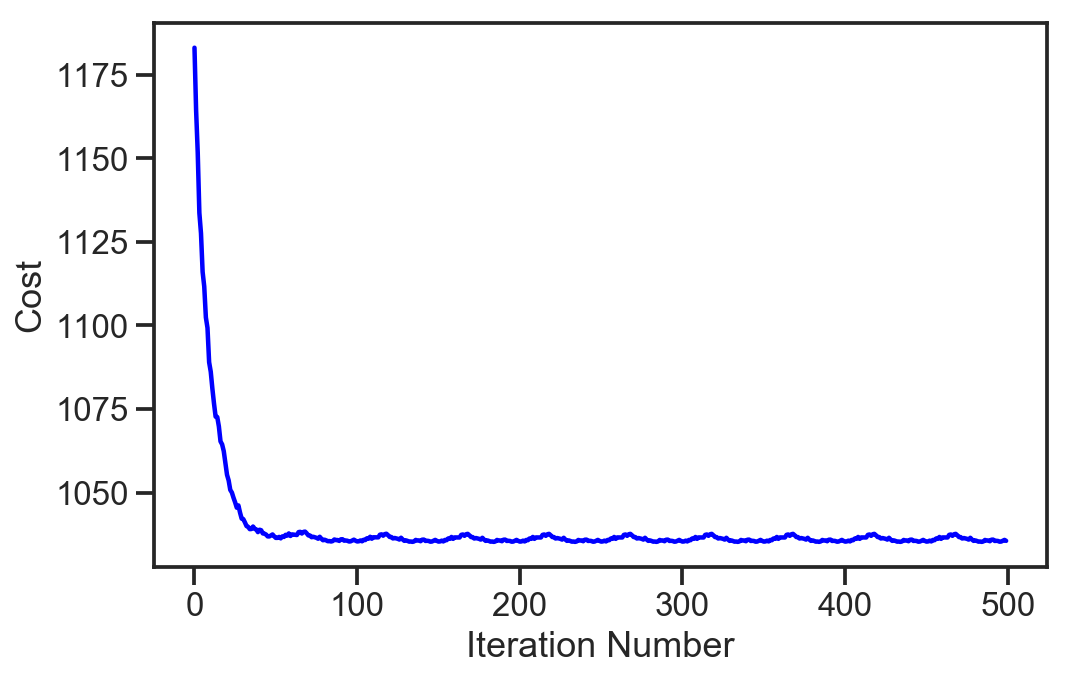

Log likelihood with fitted params:  1035.345
Log Likelihood with true params:  1059.723


In [7]:
class HMM:
    def __init__(self, M):
        self.M = M

    def fit(self, X, learning_rate=0.001, max_iter=10, V=None, p_cost=1.0, print_period=10):
        """Train HMM model using stochastic gradient descent."""

        # Determine V, the vocabulary size
        if V is None:
            V = max(max(x) for x in X) + 1
        N = len(X)

        # Initialize HMM variables
        pi0 = np.ones(self.M) / self.M          # Initial state distribution
        A0 = random_normalized(self.M, self.M)  # State transition matrix
        B0 = random_normalized(self.M, V)       # Output distribution

        thx, cost = self.set(pi0, A0, B0)

        # This is a beauty of theano and it's computational graph. 
        # By defining a cost function, which is representing p(x), 
        # the probability of a sequence, we can then find the gradient
        # of the cost with respect to our parameters (pi, A, B). 
        # The gradient updated rules are applied as usual. Note, the 
        # reason that this is stochastic gradient descent is because
        # we are only looking at a single training example at a time.
        pi_update = self.pi - learning_rate * T.grad(cost, self.pi)
        pi_update = pi_update / pi_update.sum()

        A_update = self.A - learning_rate*T.grad(cost, self.A)
        A_update = A_update / A_update.sum(axis=1).dimshuffle(0, 'x')

        B_update = self.B - learning_rate*T.grad(cost, self.B)
        B_update = B_update / B_update.sum(axis=1).dimshuffle(0, 'x')

        updates = [
            (self.pi, pi_update),
            (self.A, A_update),
            (self.B, B_update),
        ]

        train_op = theano.function(
            inputs=[thx],
            updates=updates,
            allow_input_downcast=True
        )

        costs = []
        for it in range(max_iter):
            for n in range(N):
                # Looping through all N training examples
                c = self.get_cost_multi(X, p_cost).sum()
                costs.append(c)
                train_op(X[n])

        print("A learned from training: \n", self.A.get_value())
        print("B learned from training: \n", self.B.get_value())
        print("pi learned from training: \n", self.pi.get_value())

        plt.figure(figsize=(8,5))
        plt.plot(costs, color="blue")
        plt.xlabel("Iteration Number")
        plt.ylabel("Cost")
        plt.show()

    def get_cost(self, x):
        return self.cost_op(x)

    def get_cost_multi(self, X, p_cost=1.0):
        P = np.random.random(len(X))
        return np.array([self.get_cost(x) for x, p in zip(X, P) if p < p_cost])

    def log_likelihood(self, x):
        return - self.cost_op(x)

    def set(self, pi, A, B):
        # Create theano shared variables
        self.pi = theano.shared(pi)
        self.A = theano.shared(A)
        self.B = theano.shared(B)

        # Define input, a vector
        thx = T.ivector("thx")

        def recurrence_to_find_alpha(t, old_alpha, x):
            """
            Scaled version of updates for HMM. This is used to find the 
            forward variable alpha.

            Args:
                t:         Current time step, from pass in from scan:
                           sequences=T.arange(1, thx.shape[0])
                old_alpha: Previously returned alpha, or on the first time step 
                           the initial value, 
                           outputs_info=[self.pi *  self.B[:, thx[0]], None]
                x:         thx, non_sequences (our actual set of observations)
            """
            alpha = old_alpha.dot(self.A) * self.B[:, x[t]]
            s = alpha.sum()
            return (alpha / s), s

        # alpha and scale, once returned, are both matrices with values at each time step
        [alpha, scale], _ = theano.scan(
            fn=recurrence_to_find_alpha,
            sequences=T.arange(1, thx.shape[0]),
            outputs_info=[self.pi *  self.B[:, thx[0]], None],    # Initial value of alpha
            n_steps=thx.shape[0] - 1,
            non_sequences=thx,
        )

        # scale is an array, and scale.prod() = p(x)
        # The property log(A) + log(B) = log(AB) can be used 
        # here to prevent underflow problem
        p_of_x = -T.log(scale).sum()      # Negative log likelihood
        cost = p_of_x

        self.cost_op = theano.function(
            inputs=[thx],
            outputs=cost,
            allow_input_downcast=True,
        )
        return thx, cost


def fit_coin(file_key):
    """Loads data and trains HMM."""

    X = []
    for line in get_obj_s3(file_key).read().decode("utf-8").strip().split(sep="\n"):
        x = [1 if e == "H" else 0 for e in line.rstrip()]
        X.append(x)

    # Instantiate object of class HMM with 2 hidden states (heads and tails)
    hmm = HMM(2)
    hmm.fit(X)
    L = hmm.get_cost_multi(X).sum()
    print("Log likelihood with fitted params: ", round(L, 3))

    # Try the true values
    pi = np.array([0.5, 0.5])
    A = np.array([
        [0.1, 0.9],
        [0.8, 0.2]
    ])
    B = np.array([
        [0.6, 0.4],
        [0.3, 0.7]
    ])
    hmm.set(pi, A, B)
    L = hmm.get_cost_multi(X).sum()
    print("Log Likelihood with true params: ", round(L, 3))


if __name__ == "__main__":
    key = "coin_data.txt"
    fit_coin(key)

## 3. HMM's with Theano $\rightarrow$ Optimization via Softmax
One of the challenges of the approach we took is that gradient descent is _unconstrained_; it simply goes in the direction of the gradient. This presents a problem for us in the case of HMM's. Remember, the parameters of an HMM are $\pi$, $A$, and $B$, and each is a probability matrix/vector. This means that they must be between 0 and 1, and must sum to 1 (along the rows if 2-D). 

We accomplished this in the previous section by performing a "hack". Specifically, we renormalized after each gradient descent step. However, this means that we weren't performing _real_ gradient descent, because by renormalizing we are not exactly moving in the direction of the gradient anymore. For reference, the pseudocode looked like this:

```
pi_update = self.pi - learning_rate * T.grad(cost, self.pi)
pi_update = pi_update / pi_update.sum() # Normalizing to ensure it stays a probability

A_update = self.A - learning_rate*T.grad(cost, self.A)
A_update = A_update / A_update.sum(axis=1).dimshuffle(0, 'x') # Normalize for prob                           
B_update = self.B - learning_rate*T.grad(cost, self.B)
B_update = B_update / B_update.sum(axis=1).dimshuffle(0, 'x') # Normalize for prob

# Passing in normalized updates for pi, A, B. No longer moving in dir of gradient
updates = [
    (self.pi, pi_update),
    (self.A, A_update),
    (self.B, B_update),
]
```

This leads us to the question: is it possible to use true gradient descent, while still conforming to the constraints that each parameter much be a true probability. The answer is of course yes!

### 3.1 Softmax 
If you are unfamiliar with Deep Learning then you may want to jump over this section, or go through my deep learning posts that dig into the subject. If you are familiar, recall the softmax function:

$$softmax(x)_i = \frac{exp(x_i)}{\sum_{k=1}^K exp(x_k)}$$

Where $x$ is an array of size $K$, and $K$ is the number of classes that we have. The result of the softmax is that all outputs are positive and sum to 1. What exactly does this mean in our scenario? 

#### Softmax for $\pi$
Consider $\pi$, an array of size $M$. Supposed we want to parameterize $\pi$, using the symbol $\theta$. We can then assign $\pi$ to be:

$$pi = softmax(\theta)$$

In this way, $\pi$ is like an intermediate variable and $\theta$ is the actual parameter that we will be updating. This ensures that $\pi$ is always between 0 and 1, and sums to 1. At the same time, the values in $\theta$ can be anything; this means that we can freely use gradient descent on $\theta$ without having to worry about any constraints! No matter what we do to $\theta$, $\pi$ will always be between 0 and 1 and sum to 1. 

#### Softmax for $A$ and $B$
Now, what about $A$ and $B$? Unlike $\pi$, which was a 1-d vector, $A$ and $B$ are matrices. Luckily for us, softmax works well for us here too! Recall that when dealing with data in deep learning (and most ML) that we are often dealing with multiple samples at the same time. Typically an $NxD$ matrix, where $N$ is the number of samples, and $D$ is the dimensionality. We know that the output of our model is usually an $NxK$ matrix, where $K$ is the number of classes. Naturally, because the classes go along the rows, each row must represent a separate probability distribution. 

Why is this helpful? Well, the softmax was actually written with this specifically in mind! When you use the softmax it automatically exponentiates every element of the matrix and divides by the row sum. That is exactly what we want to do with $A$ and $B$! Each row of $A$ is the probability of the next state to transition to, and each row of $B$ is the probability of the next symbol to emit. The rows must sum to 1, just like the output predictions of a neural network! 

In pseudocode, softmax looks like:

```
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)
```

We can see this clearly below:

In [37]:
np.set_printoptions(suppress=True)

A = np.array([
    [1,2],
    [4,5],
    [9,5]
])

expA = np.exp(A)
print("A exponentiated element wise: \n", np.round_(expA, decimals=3), "\n")

# Keep dims ensures a column vector (vs. row) output
output = expA / expA.sum(axis=1, keepdims=True) 
print("Exponentiated A divided row sum: \n", np.round_(output, decimals=3))

A exponentiated element wise: 
 [[   2.718    7.389]
 [  54.598  148.413]
 [8103.084  148.413]] 

Exponentiated A divided row sum: 
 [[0.269 0.731]
 [0.269 0.731]
 [0.982 0.018]]


Now you may be wondering: Why can't we just perform standard normalization? Why does the exponetial need to be used? For an answer to that I recommend reading up [here](https://stackoverflow.com/questions/17187507/why-use-softmax-as-opposed-to-standard-normalization), [here](https://stats.stackexchange.com/questions/162988/why-sigmoid-function-instead-of-anything-else/318209#318209), and [here](http://cs231n.github.io/linear-classify/#softmax).

### 3.2 Update Discrete HMM Code $\rightarrow$ with Softmax

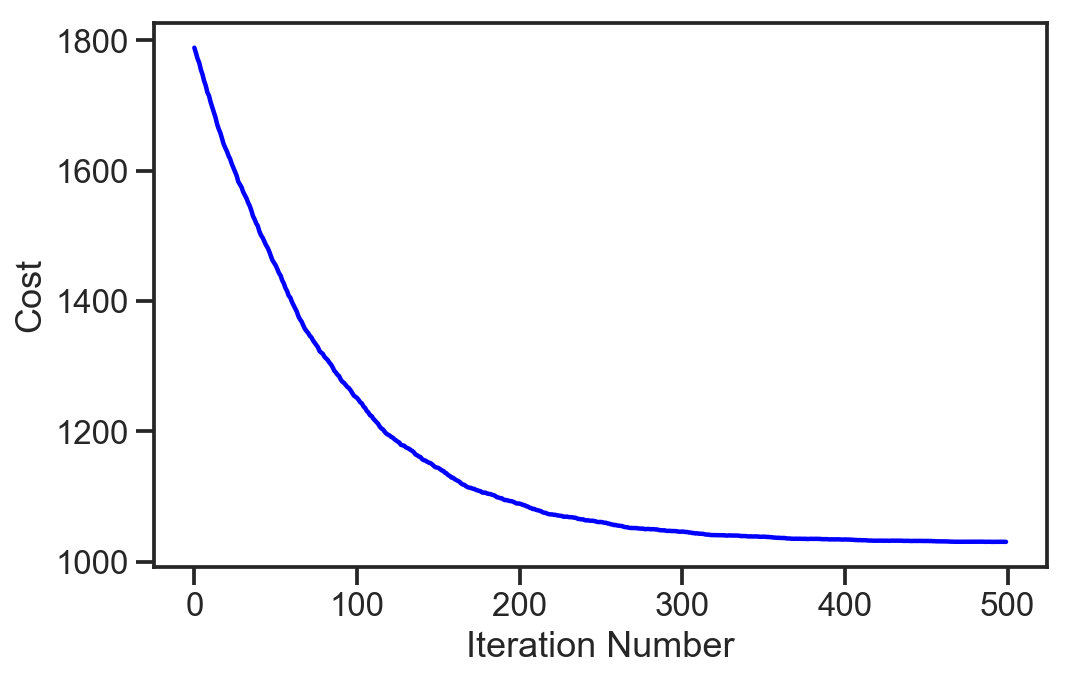

Log likelihood with fitted params:  1030.369
Log Likelihood with true params:  1047.421


In [43]:
class HMM:
    def __init__(self, M):
        self.M = M

    def fit(self, X, learning_rate=0.001, max_iter=10, V=None, p_cost=1.0, print_period=10):
        """Train HMM model using stochastic gradient descent."""

        # Determine V, the vocabulary size
        if V is None:
            V = max(max(x) for x in X) + 1
        N = len(X)

        preSoftmaxPi0 = np.zeros(self.M) # initial state distribution
        preSoftmaxA0 = np.random.randn(self.M, self.M) # state transition matrix
        preSoftmaxB0 = np.random.randn(self.M, V) # output distribution

        thx, cost = self.set(preSoftmaxPi0, preSoftmaxA0, preSoftmaxB0)

        # This is a beauty of theano and it's computational graph. By defining a cost function,
        # which is representing p(x), the probability of a sequence, we can then find the gradient
        # of the cost with respect to our parameters (pi, A, B). The gradient updated rules are
        # applied as usual. Note, the reason that this is stochastic gradient descent is because
        # we are only looking at a single training example at a time.
        pi_update = self.preSoftmaxPi - learning_rate * T.grad(cost, self.preSoftmaxPi)
        A_update = self.preSoftmaxA - learning_rate * T.grad(cost, self.preSoftmaxA)
        B_update = self.preSoftmaxB - learning_rate * T.grad(cost, self.preSoftmaxB)

        updates = [
            (self.preSoftmaxPi, pi_update),
            (self.preSoftmaxA, A_update),
            (self.preSoftmaxB, B_update),
        ]

        train_op = theano.function(
            inputs=[thx],
            updates=updates,
            allow_input_downcast=True
        )

        costs = []
        for it in range(max_iter):
            for n in range(N):
                # Looping through all N training examples
                c = self.get_cost_multi(X, p_cost).sum()
                costs.append(c)
                train_op(X[n])

        plt.figure(figsize=(8,5))
        plt.plot(costs, color="blue")
        plt.xlabel("Iteration Number")
        plt.ylabel("Cost")
        plt.show()

    def get_cost(self, x):
        return self.cost_op(x)

    def get_cost_multi(self, X, p_cost=1.0):
        P = np.random.random(len(X))
        return np.array([self.get_cost(x) for x, p in zip(X, P) if p < p_cost])

    def log_likelihood(self, x):
        return - self.cost_op(x)

    def set(self, preSoftmaxPi, preSoftmaxA, preSoftmaxB):
        # Create theano shared variables
        self.preSoftmaxPi = theano.shared(preSoftmaxPi)
        self.preSoftmaxA = theano.shared(preSoftmaxA)
        self.preSoftmaxB = theano.shared(preSoftmaxB)

        pi = T.nnet.softmax(self.preSoftmaxPi).flatten()
        # softmax returns 1xD if input is a 1-D array of size D
        A = T.nnet.softmax(self.preSoftmaxA)
        B = T.nnet.softmax(self.preSoftmaxB)

        # Define input, a vector
        thx = T.ivector("thx")

        def recurrence_to_find_alpha(t, old_alpha, x):
            """Scaled version of updates for HMM. This is used to find the forward variable alpha.

                Args:
                    t:         Current time step, from pass in from scan:
                               sequences=T.arange(1, thx.shape[0])
                    old_alpha: Previously returned alpha, or on the first time step the initial value,
                               outputs_info=[pi *  B[:, thx[0]], None]
                    x:         thx, non_sequences (our actual set of observations)
            """
            alpha = old_alpha.dot(A) * B[:, x[t]]
            s = alpha.sum()
            return (alpha / s), s

        # alpha and scale, once returned, are both matrices with values at each time step
        [alpha, scale], _ = theano.scan(
            fn=recurrence_to_find_alpha,
            sequences=T.arange(1, thx.shape[0]),
            outputs_info=[pi *  B[:, thx[0]], None],    # Initial value of alpha
            n_steps=thx.shape[0] - 1,
            non_sequences=thx,
        )

        # scale is an array, and scale.prod() = p(x)
        # The property log(A) + log(B) = log(AB) can be used here to prevent underflow problem
        p_of_x = -T.log(scale).sum()      # Negative log likelihood
        cost = p_of_x

        self.cost_op = theano.function(
            inputs=[thx],
            outputs=cost,
            allow_input_downcast=True,
        )
        return thx, cost


def fit_coin(file_key):
    """Loads data and trains HMM."""

    X = []
    for line in get_obj_s3(file_key).read().decode("utf-8").strip().split(sep="\n"):
        x = [1 if e == "H" else 0 for e in line.rstrip()]
        X.append(x)

    # Instantiate object of class HMM with 2 hidden states (heads and tails)
    hmm = HMM(2)
    hmm.fit(X)
    L = hmm.get_cost_multi(X).sum()
    print("Log likelihood with fitted params: ", round(L, 3))

    # Try the true values
    pi = np.array([0.5, 0.5])
    A = np.array([
        [0.1, 0.9],
        [0.8, 0.2]
    ])
    B = np.array([
        [0.6, 0.4],
        [0.3, 0.7]
    ])
    hmm.set(pi, A, B)
    L = hmm.get_cost_multi(X).sum()
    print("Log Likelihood with true params: ", round(L, 3))


if __name__ == "__main__":
    key = "coin_data.txt"
    fit_coin(key)

## 4. Hidden Markov Models with TensorFlow
I now want to expose everyone to an HMM implementation in TensorFlow. In order to do so, we will need to first go over the `scan` function in Tensorflow. Just like when dealing with Theano, we need to ask "What is the equivalent of a for loop in TensorFlow?". And why should we care? 

### 4.1 TensorFlow Scan
In order to understand the importance of `scan`, we need to be sure that we have a good idea of how TensorFlow works, even if only from a high level. In general, with both TensorFlow and Theano, you have to create variables and link them together functionally, but they do not have values until you actually run the functions. So, when you create your $X$ matrix you don't give it a shape; you just say here is a place holder I am going to call $X$ and this is a possible shape for it:

```
X = tf.placeholder(tf.float32, shape=(None, D))
```

However, remember that the `shape` argument is _optional_, and hence for all intents and purposes we can assume that we do not know the shape of $X$. So, what happens if you want to loop through all the elements of $X$? Well you can't, because we do not know the number of elements in $X$!

```
for i in range(X.shape[0]): <------- Not possible! We don't know num elements in X
    # ....
```

In order to write a for loop we must specify the number of times the loop will run. But in order to specify the number of times the loop will run we must know the number of elements in $X$. Generally speaking, we cannot guarantee the length of our training sequences. This is why we need the tensorflow `scan` function! It will allow us to loop through a tensorflow array without knowing its size. This is similar to how everything else in Tensorflow and Theano works. Using `scan` we can tell Tensorflow "how to run the for loop", without actually running it. 

There is another big reason that the `scan` function is so important; it allows us to perform **automatic differentiation** when we have sequential data. Tensorflow keeps track of how all the variables in your graph link together, so that it can automatically calculate the gradient for you when you do gradient descent:

$$W(t) \leftarrow W(t-1) - \eta \nabla J\big(W(t-1)\big)$$

The `scan` function keeps track of this when it performs the loop. The anatomy of the `scan` function is shown in pseudocode below:

```
outputs = tf.scan(
    fn=some_function,          # Function applied to every element in sequence 
    elems=thing_to_loop_over   # Actual sequence that is passed in
)
```

Above, `some_function` is applied to every element in `thing_to_loop_over`. Now, the way that we define `some_function` is very specific and much more strict than that for theano. In particular, it must always take in two arguments. The first element is the last output of the function, and the second element is the next element of the sequence:

```
def some_function(last_output, element):
    return do_something_to(last_output, element)
```

The tensorflow scan function returns `outputs`, which is all of the return values of `some_function` concatenated together. For example, we can look at the following block:

```
outputs = tf.scan(
    fn=some_function,          
    elems=thing_to_loop_over  
)

def square(last, current):
    return current * current
   
# sequence = [1, 2, 3]
# outputs = [1, 4, 9]
```

If we pass in `[1, 2, 3]`, then our outputs will be `[1, 4, 9]`. Now, of course the outputs is still a tensorflow graph node. So, in order to get an actual value out of it we need to run it in an actual session. 

In [48]:
import tensorflow as tf

x = tf.placeholder(tf.int32, shape=(None,), name="x")

def square(last, current):
    """Last is never used, but must be included based on interface requirements of tf.scan"""
    return current*current

# Essentially doing what a for loop would normally do
# It applies the square function to every element of x
square_op = tf.scan(
    fn=square,
    elems=x
)

# Run it!
with tf.Session() as session:
    o_val = session.run(
        square_op,
        feed_dict={x: [1, 2, 3, 4, 5]}
    )
    print("Output: ", o_val)


Output:  [ 1  4  9 16 25]


Now, of course `scan` can do more complex things than this. We can implement another argument, `initializer`, that allows us to compute recurrence relationships.  

```
outputs = tf.scan(
    fn=some_function,          # Function applied to every element in sequence 
    elems=thing_to_loop_over,  # Actual sequence that is passed in
    initializer=initial_input  
)
```

Why exactly do we need this? Well, we can see that the recurrence function takes in two things: the last element that it returned, and the current element of the sequence that we are iterating over. What is the last output during the first iteration? There isn't one yet! And that is exactly why we need `initializer`. 

One thing to keep in mind when using `initializer` is that it is very strict. In particular, it must be the exact same type as the output of `recurrence`. For example, if you need to return multiple things from `recurrence` it is going to be returned as a tuple. That means that the argument to `initializer` cannot be a list, it must be a tuple. This also means that a tuple containing `(5 , 5)` is not the same a tuple containing `(5.0, 5.0)`. 

Let's try to compute the fibonacci sequence to get a feel for how this works:

In [50]:
# N is the number fibonacci numbers that we want
N = tf.placeholder(tf.int32, shape=(), name="N")

def fibonacci(last, current):
    # last[0] is the last value, last[1] is the second last value
    return (last[1], last[0] + last[1])


fib_op = tf.scan(
    fn=fibonacci,
    elems=tf.range(N),
    initializer=(0, 1),
)

with tf.Session() as session:
    o_val = session.run(
        fib_op,
        feed_dict={N: 8}
    )
    print("Output: \n", o_val)

Output: 
 (array([ 1,  1,  2,  3,  5,  8, 13, 21], dtype=int32), array([ 1,  2,  3,  5,  8, 13, 21, 34], dtype=int32))
